All the necessary imports

In [65]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
from spacy.matcher import Matcher
from collections import Counter
import json
from spacy.tokens import DocBin
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
!python -m spacy download hr_core_news_lg
# Load Croatian language model
nlp = spacy.load('hr_core_news_lg')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 MB 6.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('hr_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:
def read_letters(folder_path):
    """
    Reads all letters from the specified folder
    Returns a DataFrame with filename and content
    """
    letters = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                letters.append({
                    'filename': filename,
                    'content': content
                })

    print(f"Loaded {len(letters)} letters.")

    return pd.DataFrame(letters)

In [93]:
use_gdrive = True
gdrive_path = 'drive/MyDrive/nlp_master_raf/' if use_gdrive else ""
letters_df = read_letters(gdrive_path + "letters")

Loaded 12 letters.


### Task 2:
Splitting the letters into sentences and performing the analysis.

In [32]:
def analyze_sentences(df):
    """
    Analyzes sentences in each letter, focusing on length and complexity
    Returns DataFrame with detailed sentence analysis
    """
    sentence_analysis = []

    for _, row in df.iterrows():
        doc = nlp(row['content'])

        # Analyze each sentence
        for sent in doc.sents:
            # Count words (excluding punctuation)
            word_count = len([token for token in sent if not token.is_punct])

            # Calculate average word length (excluding punctuation)
            avg_word_length = sum(len(token.text) for token in sent if not token.is_punct) / word_count if word_count > 0 else 0

            sentence_analysis.append({
                'filename': row['filename'],
                'sentence': sent.text,
                'word_count': word_count,
                'avg_word_length': round(avg_word_length, 2),
                'is_long': word_count > 20  # Flag for long sentences
            })

    return pd.DataFrame(sentence_analysis)

def get_sentence_statistics(sentence_df):
    """
    Calculates statistical summary of sentence analysis
    """
    stats = {
        'total_sentences': len(sentence_df),
        'avg_sentence_length': sentence_df['word_count'].mean(),
        'long_sentences_count': len(sentence_df[sentence_df['is_long']]),
        'max_sentence_length': sentence_df['word_count'].max(),
        'min_sentence_length': sentence_df['word_count'].min()
    }
    return stats


def analyze_letters_sentences(letters_df):
    """
    Main function to analyze all letters and their sentences
    """
    # Analyze sentences
    sentence_analysis = analyze_sentences(letters_df)

    # Get statistics
    stats = get_sentence_statistics(sentence_analysis)

    # Get notable sentences (longer than 20 words)
    long_sentences = sentence_analysis[sentence_analysis['is_long']].sort_values('word_count', ascending=False)

    return letters_df, sentence_analysis, stats, long_sentences

def print_analysis_summary(stats, long_sentences):
    print("\nSentence Analysis in Andrić's Letters:")
    print("=====================================")
    print(f"Total number of analyzed sentences: {stats['total_sentences']}")
    print(f"Average sentence length: {stats['avg_sentence_length']:.2f} words")
    print(f"Number of long sentences (>20 words): {stats['long_sentences_count']}")
    print(f"Longest sentence has {stats['max_sentence_length']} words")
    print("=====================================")

    len_long_sentences = stats['long_sentences_count']
    # check whether long sentences is not empty
    if len_long_sentences != 0:
        # print first min between len of long_sentences and 3
        print("\nExamples of the longest sentences:")
        print("=====================================")

        for _, row in long_sentences.head(min(len_long_sentences, 7)).iterrows():
            print(f"Letter: {row['filename']}")
            print(f"Sentence: {row['sentence']}")
            print(f"Word count: {row['word_count']}")
            print(f"Avg. word length: {row['avg_word_length']}")
            print()



Andrić writes relatively short sentences, there are only around 15% of sentences that have more than 20 words. The average sentence length is 12 words. His writting style is simplistic and easy to read, there are not many unnecessary adjectives in them.

In [33]:
letters_df, sentence_analysis, stats, long_sentences = analyze_letters_sentences(letters_df)
sentences = sentence_analysis['sentence']
print_analysis_summary(stats, long_sentences)


Sentence Analysis in Andrić's Letters:
Total number of analyzed sentences: 79
Average sentence length: 12.16 words
Number of long sentences (>20 words): 14
Longest sentence has 36 words

Examples of the longest sentences:
Letter: letter_2.txt
Sentence: Gledaću svakako da dođem па jedan dan u
Zagreb, kad budem polazio па odmor; а dotle, držite se
dobro i budite tvrdi kao uvek, dragi, stari mој Tugomire.
Grli Vas i pozdravlja

Word count: 36
Avg. word length: 3.92

Letter: letter_5.txt
Sentence: ,
šaljem vam u prilogu 50 franaka i molim vas da
budete ljubazni i da mi pošaljete Antologiju Lirike "Misli"
(poslednje izdanje, sa slikаmа) i Antologiju Ljubavnе Lirike 
od g. Bož. Kovačevića.

Word count: 36
Avg. word length: 4.39

Letter: letter_2.txt
Sentence: Ра ipak hocu da vam se javim sa dve
reči, da Vam kažem ono što dobro znate, koliko učestvujem
u Vašoj bolesti i kako Vam od srca želim
zdravlje i svako dobro.
Word count: 35
Avg. word length: 3.63

Letter: letter_11.txt
Sentence: - Čit

### Task 3:
Tokenizing the words and removing the stopwords.

In [34]:
def tokenize(sentences):
    """
    Tokenize the input sentences

    Parameters:
    sentences (list): List of sentences to tokenize

    Returns:
    list: List of lists where each inner list contains tokens for one sentence
    """
    tokenized_sentences = []

    for sentence in sentences:
        doc = nlp(sentence)
        # Get all tokens that aren't punctuation or whitespace
        tokens = [token.text.lower() for token in doc
                if not token.is_punct and not token.is_space]
        tokenized_sentences.append(tokens)

    return tokenized_sentences

def remove_stop_words(sentences):
    """
    Remove stop words from tokenized sentences

    Parameters:
    sentences (list): List of lists containing tokenized sentences

    Returns:
    list: List of lists with stop words removed
    """
    cleaned_sentences = []

    for sentence in sentences:
        # Process each token to check if it's a stop word
        cleaned_tokens = [token for token in sentence
                        if not nlp.vocab[token].is_stop]
        cleaned_sentences.append(cleaned_tokens)

    return cleaned_sentences

In [35]:
tokenized_sentences = tokenize(sentences)
cleaned_sentences = remove_stop_words(tokenized_sentences)
print("Tokenized sentence: \n")
print(tokenized_sentences[3])
print("##############################################")
print("After removing stop words: \n")
print(cleaned_sentences[3])

Tokenized sentence: 

['zadovoljan', 'sam', 'da', 'је', 'tako']
##############################################
After removing stop words: 

['zadovoljan', 'је']


### Task 4:
Stemming vs Lemmatization
Couldn't find library which supports stemming for Serbian language, so I used only lemmatization. Also lemmatization should be more suitable for this task, as Serbian language is really complex and has a lot of exceptions.

In [36]:
def perform_lemmatization(sentences):
    """
    Perform lemmatization on sentences

    Parameters:
    sentences (list): List of sentences

    Returns:
    list: List of lists containing lemmatized tokens
    """
    lemmatized_sentences = []

    for sentence in sentences:
        doc = nlp(sentence)
        lemmas = [token.lemma_ for token in doc
                if not token.is_punct and not token.is_space]
        lemmatized_sentences.append(lemmas)

    return lemmatized_sentences

def compare_lemmatized_sentences(original_sentences, lemmatized_sentences):
    """
    Compare original and lemmatized sentences

    Parameters:
    original_sentences (list): List of original sentences
    lemmatized_sentences (list): List of lemmatized tokens
    """
    for i in range(len(original_sentences)):
        print(f"{i} sentence")
        print(f"\nOriginal: {original_sentences[i]}")
        print(f"Lemmatized: {' '.join(lemmatized_sentences[i])}")
        print("##############################################")



def compare_words_and_lemmas(sentences):
    """
    Compare original tokens with their lemmatized forms

    Parameters:
    sentences (list): List of sentences

    Returns:
    list: List of tuples containing (original_token, lemma)
    """
    token_lemma_pairs = []

    for sentence in sentences:
        doc = nlp(sentence)
        # Get pairs of tokens and their lemmas
        pairs = [(token.text, token.lemma_) for token in doc
                if not token.is_punct and not token.is_space]
        token_lemma_pairs.extend(pairs)

    return token_lemma_pairs


In [37]:
examples = [2, 3, 46, 7]
example_sentences = [sentences[i] for i in examples]
lemmatized_sentences = perform_lemmatization(example_sentences)
compare_lemmatized_sentences(example_sentences, lemmatized_sentences)


0 sentence

Original: Telefonirao sam gospođi
koja me uverava da ima dobre vesti.
Lemmatized: Telefonirao biti gospođi koji ja uveravati da imati dobar vest
##############################################
1 sentence

Original: Zadovoljan
sam da је tako.
Lemmatized: Zadovoljan biti da је tako
##############################################
2 sentence

Original: Nemira.
Lemmatized: Nemir
##############################################
3 sentence

Original: Sad, kad је sve па dobrom putu, nadam se da ćemo
se još ovoga leta videti i porazgovarati, i radujem se
unapred.
Lemmatized: sad kad је sve па dobar put nadati sebe da htjeti sebe još ovaj let videti i porazgovarati i radujeti sebe unapred
##############################################


Word Pattern Analysis:

1. Prepositions frequency: There is a notable presence of prepositions in the text, which suggests complex sentence structures and detailed descriptions of relationships between objects, people, and concepts.

Emotional Tone Dichotomy:
1. Positive language when referring to others:
- The words used to describe or address other people tend to be gentle and endearing
- This suggests a respectful and warm approach in his interpersonal communications

In [38]:
# Get word-lemma pairs for comparison
word_lemma_pairs = compare_words_and_lemmas(sentences)

print("Word-Lemma pairs: \n")
cnt = 0
for word, lemma in word_lemma_pairs:
    if cnt > 70:
        break
    if word != lemma:
        print(f"Word: {word}, Lemma: {lemma}")
        cnt += 1

Word-Lemma pairs: 

Word: nisam, Lemma: biti
Word: mogao, Lemma: moći
Word: vas, Lemma: vi
Word: vidim, Lemma: vidjeti
Word: pozdravlja, Lemma: pozdravljati
Word: gospođu, Lemma: gospođa
Word: Vas, Lemma: vi
Word: Uvijek, Lemma: uvijek
Word: Molim, Lemma: moliti
Word: vas, Lemma: vi
Word: pozdravite, Lemma: pozdraviti
Word: Radicu, Lemma: Radica
Word: Dragi, Lemma: dragi
Word: velikim, Lemma: velik
Word: bolnim, Lemma: bolan
Word: iznenađenjem, Lemma: iznenađenje
Word: sam, Lemma: biti
Word: saznao, Lemma: saznati
Word: ste, Lemma: biti
Word: Zagrebu, Lemma: Zagreb
Word: ste, Lemma: biti
Word: operisani, Lemma: operisati
Word: sam, Lemma: biti
Word: koja, Lemma: koji
Word: me, Lemma: ja
Word: uverava, Lemma: uveravati
Word: ima, Lemma: imati
Word: dobre, Lemma: dobar
Word: vesti, Lemma: vest
Word: sam, Lemma: biti
Word: vam, Lemma: vi
Word: se, Lemma: sebe
Word: Vam, Lemma: Vi
Word: ono, Lemma: on
Word: znate, Lemma: znati
Word: bolesti, Lemma: bolest
Word: srca, Lemma: srce
Word: želi

### Task 5:
Phrase matching and analysis

In [39]:
import re
# Function to clean text by removing unwanted characters
def clean_text(text):
    return re.sub(r'[\n.,!?;:\"\'()\-\]]', ' ', text)

# Function to extract repeated phrases from a list of sentences
def extract_repeated_phrases(sentences, min_length=2, max_length=4, top_k=10):
    matcher = Matcher(nlp.vocab)
    phrase_counts = Counter()

    for sentence in sentences:
        cleaned_sentence = clean_text(sentence)
        doc = nlp(cleaned_sentence)

        # Extract n-grams (phrases with min_length to max_length words)
        for i in range(len(doc) - min_length + 1):
            for j in range(min_length, max_length + 1):
                if i + j <= len(doc):
                    phrase = " ".join([token.text.lower() for token in doc[i:i + j]]).strip()
                    phrase_counts[phrase] += 1

    # Filter phrases that appear more than once and sort by frequency
    repeated_phrases = {phrase: count for phrase, count in phrase_counts.items() if count > 1}
    sorted_phrases = sorted(repeated_phrases.items(), key=lambda x: x[1], reverse=True)

    return sorted_phrases[:top_k]


The three most significant phrases are:
1. Molim vas (12)
2. Pozdravlja vas (7)
3. Nadam se (4)

The first phrase reflects Andrić’s humility, grace, and gentleness in addressing his friends.

The third phrase is often used in the context of expressing hope that his friends are doing well and that they will meet soon, demonstrating his care and thoughtfulness.

In [40]:
top_phrases = extract_repeated_phrases(sentences, top_k=10)
print("\nTop repeated phrases:")
print("=====================")
print("\n".join([f"{phrase}: {count}" for phrase, count in top_phrases]))


Top repeated phrases:
молим вас: 10
цвијановићу: 9
поздравља вас: 8
иво андрић: 7
mој tugomire: 6
молим вас да: 6
vaš ivo: 4
molim vas: 4
dragi mој tugomire: 4
tugomire: 4


### Task 6:
POS Tagging - Noun to Verb Ratio

In [41]:
def return_docs(sentences):
    docs = []  # store docs for visualization

    for sentence in sentences:
        doc = nlp(sentence)
        docs.append(doc)
    return docs

def visualize_dependencies(doc):
    """
    Visualize dependencies for a single sentence
    """
    options = {
        'distance': 110,
        'compact': True,
        'color': 'purple',
        'bg': 'white',
        'font': 'Times'
    }

    return spacy.displacy.render(doc, style='dep', options=options, jupyter=True)


def get_pos_distribution(pos_tags):
    """
    Calculate distribution of POS tags
    """
    return Counter(pos_tags)

def analyze_noun_verb_ratio(pos_tags):
    """
    Calculate the ratio of nouns to verbs
    """
    nouns = sum(1 for tag in pos_tags if tag == 'NOUN')
    verbs = sum(1 for tag in pos_tags if tag == 'VERB')

    ratio = nouns/verbs if verbs > 0 else 0
    return nouns, verbs, ratio

In [42]:
all_pos_tags = []

# Collect all POS tags
for sentence in sentences:
    doc = nlp(sentence)
    for token in doc:
        if not token.is_punct and not token.is_space:
            all_pos_tags.append(token.pos_)

# Get and print POS distribution
pos_dist = get_pos_distribution(all_pos_tags)
print("POS Distribution:")
print("=================")
for pos, count in pos_dist.most_common():
    print(f"{pos}: {count}")

# Get and print noun-verb analysis
nouns, verbs, ratio = analyze_noun_verb_ratio(all_pos_tags)
print(f"\nNumber of nouns: {nouns}")
print(f"Number of verbs: {verbs}")
print(f"Noun-to-Verb ratio: {ratio:.2f}")

POS Distribution:
PROPN: 202
NOUN: 127
VERB: 78
ADJ: 72
X: 55
ADV: 54
PRON: 54
CCONJ: 36
AUX: 31
ADP: 29
SCONJ: 28
DET: 27
PUNCT: 24
NUM: 18
PART: 11
SPACE: 1

Number of nouns: 127
Number of verbs: 78
Noun-to-Verb ratio: 1.63


In [43]:
# Visualize dependencies for each sentence
docs = return_docs(sentences)
print("\nDependency Visualizations:")
for doc in docs[3:7]:
    visualize_dependencies(doc)


Dependency Visualizations:


In [44]:
big_string = "\n".join(sentences)

# Save to a text file
with open(gdrive_path + "letters.txt", "w") as file:
    file.write(big_string)

### Task 7:
Named Entity Recognition (NER)

In [45]:
def analyze_entities(text):
    """
    Analyze named entities in the text

    Parameters:
    text (str): Input text to analyze

    Returns:
    tuple: (entity_counts, entity_details)
    """
    doc = nlp(text)

    # Count entities by type
    entity_counts = Counter([ent.label_ for ent in doc.ents])

    # Collect detailed entity information
    entity_details = []
    for ent in doc.ents:
        entity_details.append({
            'text': ent.text,
            'type': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char
        })

    return entity_counts, entity_details

def print_entity_analysis(entity_counts, entity_details):
    """
    Print detailed analysis of entities
    """
    print("Entity Type Distribution:")
    for ent_type, count in entity_counts.most_common():
        print(f"{ent_type}: {count}")

    print("\nDetailed Entity List:")
    # Group entities by type
    entities_by_type = {}
    for entity in entity_details:
        ent_type = entity['type']
        if ent_type not in entities_by_type:
            entities_by_type[ent_type] = []
        entities_by_type[ent_type].append(entity['text'])


    ent_types = ['PER', 'LOC']
    # Print unique entities by type
    for ent_type, entities in entities_by_type.items():
        unique_entities = set(entities)
        if ent_type in ent_types:
            print(f"\n{ent_type}:")
            for entity in sorted(unique_entities):
                print(f"  - {entity}")

def visualize_entities(text, custom_nlp=nlp):
    """
    Visualize entities in the text using displacy
    """
    doc = nlp(text)
    colors = {
        'PER': '#fca503',   # Person
        'LOC': '#03fcf0',   # Location
        'ORG': '#03fc24',   # Organization
        'MISC': '#fc0303'   # Miscellaneous
    }
    options = {'colors': colors}
    return spacy.displacy.render(doc, style='ent', options=options, jupyter=True)

# Read and analyze the letters
with open(gdrive_path + 'letters.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Perform analysis
entity_counts, entity_details = analyze_entities(text)

# Print analysis
print_entity_analysis(entity_counts, entity_details)

# Visualize entities in a sample of text
# Taking first letter as an example
first_letter = text.split('\n\n')[0]  # Adjust splitting based on your actual text structure
visualize_entities(first_letter)

Entity Type Distribution:
PER: 45
LOC: 30
ORG: 24
MISC: 9
DERIV_PER: 1

Detailed Entity List:

PER:
  - Bož
  - Cvijanoviću
  - Dušku
  - Grli
  - Ivo

Dragi Tugomire
  - Ivo

Драги г
  - Ivo Andrić
  - Julius Slowacki
  - Kovačevića
  - Rukoljub
  - Vašima
  - Vаmа
  - Vат
  - fra Augustinu
  - hocu
  - mој Tugomire
  - Аnti
  - Ако ово
потоње
  - Београд
  - Вам послати

  - Веbu
  - Веbа
  - Данила Илића
  - Књига
  - Марибора
  - Не знам да ли има
  - Петровић
  - Поздравља
  - С. K. 
Гласнику
  - Цвијановић
  - Цвијановићу
  - књигама које
  - поручите свакако
  - снимци који
  - шаљем ових
  - шаљем позаjмљену кљигу
  - њена унутрашњост

LOC:
  - Beču
  - Bogzna
  - Marseille
  - Napulj
  - Nemira
  - Placidu
  - Preboliо 

  - Rim
  - Velizar Nintchitch
  - Višegradu
  - Zagreb
  - Zagrebu
  - Švicarskoj
  - Јавите ми трошкове
  - Андрић
  - Драги
  - Драги г
  - Меni
  - Народне Банке
  - Потребно
  - Срдачно
  - Треба да
  - вас
  - да


Custom NER model training

In [50]:
cv_data = json.load(open(gdrive_path + 'annotations.json', 'r'))

print(f"Number of items in dataset {len(cv_data)}")

print(cv_data[0])

Number of items in dataset 197
['Cvijanoviću,', {'entities': [[0, 11, 'PERSON']]}]


Initilize config file

In [ ]:
!python -m spacy init fill-config /drive/MyDrive/nlp_master_raf/base_config.cfg /drive/MyDrive/nlp_master_raf/config.cfg

601164.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [51]:
# Define a function to create spaCy DocBin objects from the annotated data
def get_spacy_doc(file, data):
  # Create a blank spaCy pipeline
  nlp = spacy.blank('hr')
  db = DocBin()

  # Iterate through the data
  for text, annot in tqdm(data):
    doc = nlp.make_doc(text)
    annot = annot['entities']
    ents = []
    entity_indices = []

    # Extract entities from the annotations
    for start, end, label in annot:
      skip_entity = False
      for idx in range(start, end):
        if idx in entity_indices:
          skip_entity = True
          break
      if skip_entity:
        continue

      entity_indices = entity_indices + list(range(start, end))
      try:
        span = doc.char_span(start, end, label=label, alignment_mode='strict')
      except:
        continue

      if span is None:
        # Log errors for annotations that couldn't be processed
        err_data = str([start, end]) + "    " + str(text) + "\n"
        file.write(err_data)
      else:
        ents.append(span)
    try:
      doc.ents = ents
      db.add(doc)
    except:
      pass

  return db

In [55]:
# Split the annotated data into training and testing sets
train, test = train_test_split(cv_data, test_size=0.2)

# Display the number of items in the training and testing sets
print(len(train)), print(len(test))

# Open a file to log errors during annotation processing
file = open(gdrive_path + 'trained_models/train_file.txt','w')

# Create spaCy DocBin objects for training and testing data
db = get_spacy_doc(file, train)
db.to_disk(gdrive_path + 'trained_models/train_data.spacy')

db = get_spacy_doc(file, test)
db.to_disk(gdrive_path + 'trained_models/test_data.spacy')

# Close the error log file
file.close()

157
40


100%|██████████| 40/40 [00:00<00:00, 3508.92it/s]


Train the model

In [57]:
!python -m spacy train drive/MyDrive/nlp_master_raf/config.cfg  --output drive/MyDrive/nlp_master_raf/trained_models/output  --paths.train drive/MyDrive/nlp_master_raf/trained_models/train_data.spacy  --paths.dev drive/MyDrive/nlp_master_raf/trained_models/test_data.spacy

ℹ Saving to output directory:
drive/MyDrive/nlp_master_raf/trained_models/output
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     64.06    0.00    0.00    0.00    0.00
 25     200          9.24    806.09   59.46   68.75   52.38    0.59
 57     400          0.00      0.00   61.54   66.67   57.14    0.62
 95     600          0.00      0.00   61.54   66.67   57.14    0.62
142     800          0.00      0.00   66.67   72.22   61.90    0.67
198    1000          0.00      0.00   66.67   72.22   61.90    0.67
264    1200          0.00      0.00   66.67   72.22   61.90    0.67
348   

In [ ]:
custom_nlp = spacy.load(gdrive_path + 'trained_models/output/model-best')

# Read and analyze the letters
with open(gdrive_path + 'letters.txt', 'r', encoding='utf-8') as file:
    text = file.read()


# Visualize entities in a sample of text
# Taking first letter as an example
first_letter = text.split('\n\n')[0]  # Adjust splitting based on your actual text structure
doc = custom_nlp(first_letter)
for entity in doc.ents:
    print(f"Entity: {entity.text}, Label: {entity.label_}")

Entity: Cvijanoviću, Label: PERSON
Entity: Antologiju Lirike "Misli", Label: BOOKS
Entity: Antologiju Ljubavnе Lirike 
od g. Bož. Kovačevića., Label: BOOKS


### Task 8:
Classify the text into different categories and show confusion matrix as well as classification report.

Preparing the data

In [58]:
# Load dataset
df = pd.read_csv(gdrive_path + "letters_classification.csv")

# Encode text into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Letter"])  # Transform text into numerical features
y = df["Receiver"]  # Target labels

# Encode classes numerically if needed
y = pd.factorize(y)[0]  # Converts class names into numbers (e.g., "Cvijanovic" -> 0)

# Perform train-test split (70-30) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


Training a model

In [59]:
# Train a simple Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


Confusion matrix

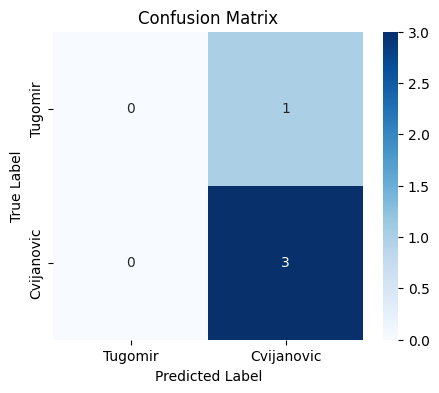

In [60]:

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d",
            xticklabels=["Tugomir","Cvijanovic"], yticklabels=["Tugomir","Cvijanovic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Classification report

In [61]:
# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Task 9:
Keyword extraction

In [62]:
keyword_doc = nlp(" ".join(sentences))

# Extract nouns
nouns = [token.text for token in keyword_doc if token.pos_ == "NOUN"]

# Join extracted nouns back into a single string
processed_text = ' '.join(nouns)

# Use TF-IDF to rank nouns
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform([processed_text])

top_k = 10

# Get the top k most important nouns
top_nouns = sorted(vectorizer.vocabulary_, key=lambda x: tfidf[0, vectorizer.vocabulary_[x]], reverse=True)[:top_k]

# Print the top k keywords
for i, noun in enumerate(top_nouns):
    print(f"{i+1}. {noun}")

1. ми
2. pozdrave
3. вам
4. госп
5. треба
6. веbu
7. gospođi
8. grip
9. срдачно
10. књигу


Wordcloud

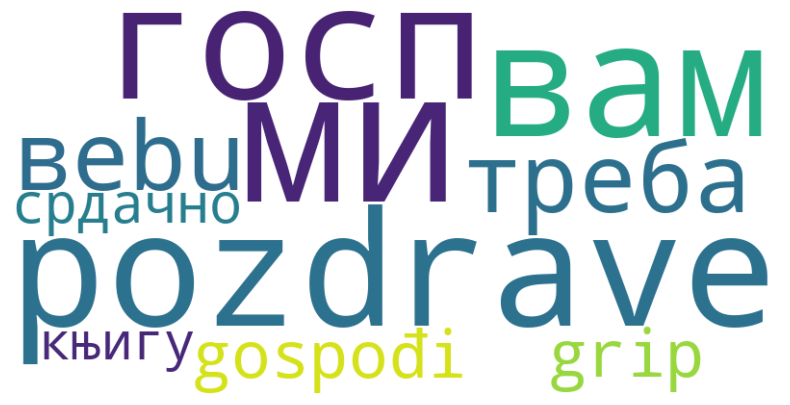

In [63]:
# WordCloud instance
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_nouns))

# Showing WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Task 11:
Sentiment Analysis

In [66]:
# Ensure required NLTK resources are downloaded
nltk.download("vader_lexicon")

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def get_sentiment(text):
    score = sia.polarity_scores(text)
    if score["compound"] >= 0.05:
        return "Positive"
    elif score["compound"] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


         filename                                            content sentiment
0    letter_1.txt  Žaleći što nisam mogao da vas јoš jednom vidim...   Neutral
1    letter_2.txt  Dragi mој Tugomire,\nsa velikim i bolnim iznen...  Negative
2    letter_3.txt  Dragi Tugomire,\nVаmа i Vašima šalje najljepše...   Neutral
3    letter_4.txt  Драги г. Цвијановић,\nзаузет свакојаким послов...   Neutral
4    letter_5.txt  Dragi gosp. Cvijanoviću,\nšaljem vam u prilogu...   Neutral
5    letter_6.txt  Драги госп. Цвијановићу,\nхвала на поздравима ...   Neutral
6    letter_7.txt  Драги госп. Цвијановићу,\nмолим вас да ми наба...   Neutral
7    letter_8.txt  Драги госп. Цвијановићу,\nданас сам примио пре...   Neutral
8    letter_9.txt  Драги г. Цвијановићу,\nмолим вас да ми пошаљет...   Neutral
9   letter_10.txt  Драги г. Цвијановићу,\nпоручите свакако, хитно...   Neutral
10  letter_11.txt  Draga gđice Веbа, došao sam samo nа tri dana u...   Neutral
11   letter_0.txt  Dragi mој Tugomire,\nodavno nemam

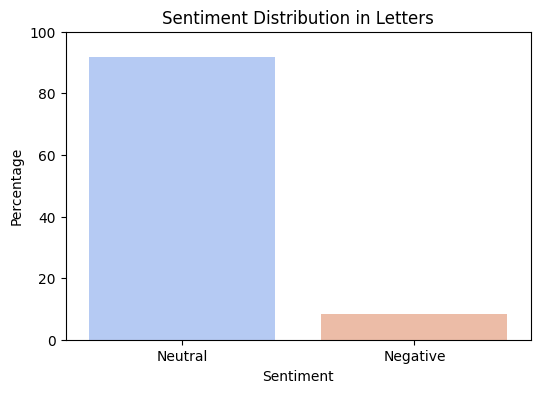

In [67]:
# Apply sentiment analysis to each letter
letters_df["sentiment"] = letters_df["content"].apply(get_sentiment)

# Calculate sentiment distribution
sentiment_counts = letters_df["sentiment"].value_counts(normalize=True) * 100

# Display sentiment analysis for each letter
print(letters_df)

# Display average sentiment distribution
print("\nSentiment Distribution (%):")
print(sentiment_counts)

# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm", hue=sentiment_counts.index)
plt.xlabel("Sentiment")
plt.ylabel("Percentage")
plt.title("Sentiment Distribution in Letters")
plt.ylim(0, 100)
plt.show()

### Task 12:
Topic modeling

In [68]:
# Function to clean and preprocess text
def clean_text(text):
    doc = nlp(text.lower())  # Convert to lowercase and process with spaCy
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and not token.is_digit
    ]
    return " ".join(tokens)

# Apply cleaning to each letter
letters_df["cleaned_content"] = letters_df["content"].apply(clean_text)

# Convert text into a Document-Term Matrix (DTM)
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(letters_df["cleaned_content"])

# Apply LDA for topic modeling
LDA = LatentDirichletAllocation(n_components=3, random_state=42)  # Adjust topic count if needed
LDA.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [69]:
# Extract top words for each topic
# Extract top words for each topic
topic_words = {}
for index, topic in enumerate(LDA.components_):
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-7:]]
    topic_words[index] = top_words  # Store top words for each topic


# Assign topics to letters
topic_assignments = LDA.transform(dtm).argmax(axis=1)
letters_df["topic"] = topic_assignments
letters_df["top_words"] = [", ".join(topic_words[t]) for t in topic_assignments]  # Add top words


# Sort letters by topic
letters_df = letters_df.sort_values(by="topic").reset_index(drop=True)

# Display cleaned DataFrame with topics
print(letters_df[["filename", "topic", "top_words"]])

         filename  topic                                          top_words
0    letter_1.txt      0  цвијановићу, иво, андрић, поздравља, молим, на...
1    letter_6.txt      0  цвијановићу, иво, андрић, поздравља, молим, на...
2    letter_9.txt      0  цвијановићу, иво, андрић, поздравља, молим, на...
3    letter_7.txt      1                  иво, андрић, вам, ми, је, вас, да
4    letter_8.txt      1                  иво, андрић, вам, ми, је, вас, да
5    letter_0.txt      1                  иво, андрић, вам, ми, је, вас, да
6   letter_10.txt      1                  иво, андрић, вам, ми, је, вас, да
7    letter_4.txt      1                  иво, андрић, вам, ми, је, вас, да
8    letter_5.txt      2         moliti, drag, tugomire, па, ivo, dobro, је
9    letter_3.txt      2         moliti, drag, tugomire, па, ivo, dobro, је
10   letter_2.txt      2         moliti, drag, tugomire, па, ivo, dobro, је
11  letter_11.txt      2         moliti, drag, tugomire, па, ivo, dobro, је


### Task 13:
RAG (Retrieval Augmented Generation)

In [70]:
from huggingface_hub import notebook_login
notebook_login()

In [71]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer
import torch

In [78]:
chechpoint = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(chechpoint)
llama_model = AutoModelForCausalLM.from_pretrained(chechpoint, torch_dtype=torch.bfloat16)
generator = pipeline("text-generation", model=llama_model, tokenizer=tokenizer)              # Create a simple text generation pipeline

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


Text Snippet Retrieval Setup

In [79]:
text_snippets = sentences


In [80]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings_text_snippets = model.encode(text_snippets)

# 🧮 Step 4: Create a function to retrieve the closest matching snippet using cosine similarity.

In [81]:
def retrieve_snippet(query):
    query_embedded = model.encode([query])                                              # Encode the query to obtain its embedding
    similarities = model.similarity(embeddings_text_snippets, query_embedded)           # Calculate cosine similarities between the query embedding and the snippet embeddings
    retrieved_texts = text_snippets[similarities.argmax().item()]                       # Retrieve the text snippet with the highest similarity
    return retrieved_texts

# 💬 Step 5: Create a function to generate the answer based on the retrieved snippet and query.


In [85]:
# In this step, we utilize the retrieved context snippets to generate a relevant answer using LLaMA, exemplifying the power of RAG in enhancing the quality of responses.

def ask_query(query):
    retrieved_texts = retrieve_snippet(query)

    # Prepare the messages for the text generation pipeline
    messages = [
        {"role": "system", "content": "You are a helpful AI assistant."
                "Provide one Answer ONLY the following query based on the context provided below. "
                "Do not generate or answer any other questions. "
                "Do not make up or infer any information that is not directly stated in the context. "
                "Provide a concise answer."
                f"{retrieved_texts}"},
        {"role": "user", "content": query}
    ]

    # Generate a response using the text generation pipeline
    response = generator(messages, max_new_tokens=128)[-1]["generated_text"][-1]["content"]
    print(f"Query: \n\t{query}")
    print(f"Context: \n\t{retrieved_texts}")
    print(f"Answer: \n\t{response}")
    print("###########################################################")

In [87]:
def ask_query_without_rag(query):
    retrieved_texts = retrieve_snippet(query)

    # Prepare the messages for the text generation pipeline
    messages = [
        {"role": "system", "content": "You are a helpful AI assistant."},
        {"role": "user", "content": query}
    ]

    # Generate a response using the text generation pipeline
    response = generator(messages, max_new_tokens=128)[-1]["generated_text"][-1]["content"]
    print(f"Query: \n\t{query}")
    print("No context provided (without RAG)")
    print(f"Answer: \n\t{response}")
    ("###########################################################")

Asking question with and without context

In [92]:
query = "Was name Tugomir mentioned in letters?"

ask_query(query)
ask_query_without_rag(query)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: 
	Was name Tugomir mentioned in letters?
Context: 
	Dragi mој Tugomire,
odavno nemam nikakvih vijesti od Vas.
Answer: 
	Tak, ime Tugomir je bilo ime v neke pripovedljivosti.
###########################################################
Query: 
	Was name Tugomir mentioned in letters?
No context provided (without RAG)
Answer: 
	I'm not aware of any specific information about a person named Tugomir being mentioned in letters. It's possible that Tugomir is a private individual or not a widely known person, which could make it harder to find information about them in letters. If you could provide more context or details about who Tugomir is or what letters you're referring to, I may be able to help you better.
